
# ДЗ5: Пуассоновское распределение

**Выбранное распределение:** Пуассоновское распределение `Poisson(λ)`.  

---

**Параметры:**  
- `λ = 7`  
- Теоретические значения:
  - $\mathbb{E}[X]=\lambda$
  - $\mathrm{Var}(X)=\lambda$

**Доверительный уровень:** **95%** (α = 0.05).

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm

np.random.seed(42)

lam = 7.0
true_mean = lam
true_var = lam
true_sd = np.sqrt(lam)

alpha = 0.05
z = norm.ppf(1 - alpha/2)

true_mean, true_var


(7.0, 7.0)


## Вспомогательные функции (ДИ)

- **Асимптотический ДИ для среднего по ЦПТ:**  
  $\bar X \pm z_{1-\alpha/2}\cdot s/\sqrt{n}$

- **t-интервал для среднего:**  
  $\bar X \pm t_{n-1,1-\alpha/2}\cdot s/\sqrt{n}$

- **Бутстрэп Эфрона:** берём квантили бутстрэп-статистик на уровнях `α/2` и `1-α/2`.


In [2]:

def ci_clt_mean(x, alpha=0.05):
    '''Asymptotic (CLT) CI for mean using z critical and sample std.'''
    x = np.asarray(x)
    n = len(x)
    xbar = x.mean()
    s = x.std(ddof=1)
    z = norm.ppf(1 - alpha/2)
    half = z * s / np.sqrt(n)
    return (xbar - half, xbar + half)

def ci_t_mean(x, alpha=0.05):
    '''Classic t-interval for mean.'''
    x = np.asarray(x)
    n = len(x)
    xbar = x.mean()
    s = x.std(ddof=1)
    t = stats.t.ppf(1 - alpha/2, df=n-1)
    half = t * s / np.sqrt(n)
    return (xbar - half, xbar + half)

def sample_mode_discrete(x):
    '''Sample mode for discrete data: smallest value with maximal frequency.'''
    x = np.asarray(x)
    vals, counts = np.unique(x, return_counts=True)
    return vals[np.argmax(counts)]

def bootstrap_ci(x, stat_func, B=5000, alpha=0.05, random_state=123):
    '''Efron percentile bootstrap CI.'''
    rng = np.random.default_rng(random_state)
    x = np.asarray(x)
    n = len(x)
    stats_boot = np.empty(B)
    for b in range(B):
        xb = rng.choice(x, size=n, replace=True)
        stats_boot[b] = stat_func(xb)
    lo = np.quantile(stats_boot, alpha/2)
    hi = np.quantile(stats_boot, 1 - alpha/2)
    return (lo, hi)

def ci_width(ci):
    return float(ci[1] - ci[0])

def inside(value, ci):
    return (ci[0] <= value) and (value <= ci[1])



## **1) Сходимость выборочного среднего к математическому ожиданию**

Сгенерируем одну большую выборку и построим **нарастающее среднее**.  
Ожидаемая стабилизация происходит около $\mathbb{E}[X]=\lambda$.


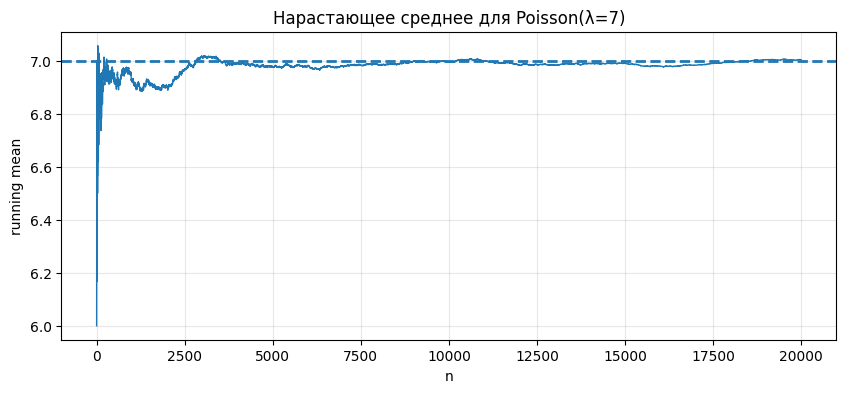

Теоретическое E[X] = 7.0
Среднее по всей выборке = 7.00455


In [3]:

N = 20000
x = np.random.poisson(lam=lam, size=N)

running_mean = np.cumsum(x) / np.arange(1, N+1)

plt.figure(figsize=(10, 4))
plt.plot(running_mean, linewidth=1)
plt.axhline(true_mean, linestyle="--", linewidth=2)
plt.title("Нарастающее среднее для Poisson(λ=7)")
plt.xlabel("n")
plt.ylabel("running mean")
plt.grid(True, alpha=0.3)
plt.show()

print("Теоретическое E[X] =", true_mean)
print("Среднее по всей выборке =", x.mean())



**Вывод:** нарастающее среднее стабилизируется около $\lambda$. Колебания уменьшаются при росте `n` (закон больших чисел).



## **2) Наглядная демонстрация центральной предельной теоремы (ЦПТ)**

Для Пуассона известны $\mathbb{E}[X]=\lambda$ и $\mathrm{Var}(X)=\lambda$.

Рассмотрим стандартизованную величину:
$
Z_n = \frac{\bar X_n - \lambda}{\sqrt{\lambda/n}}.
$
ЦПТ утверждает, что при больших `n` распределение $Z_n$ близко к $N(0,1)$.


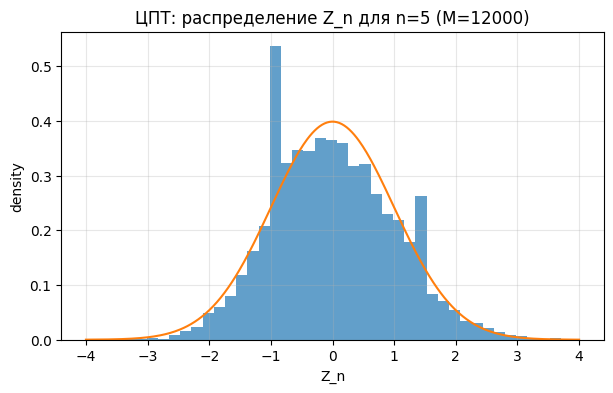

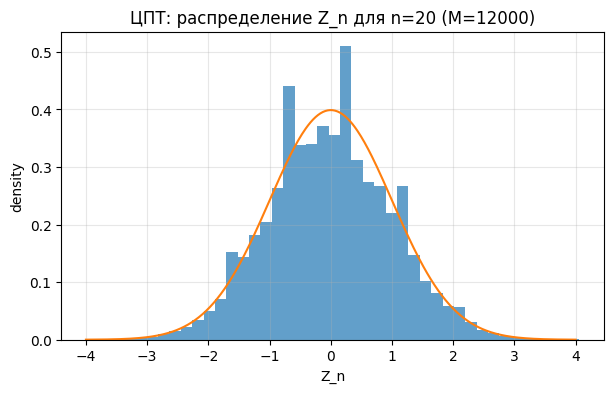

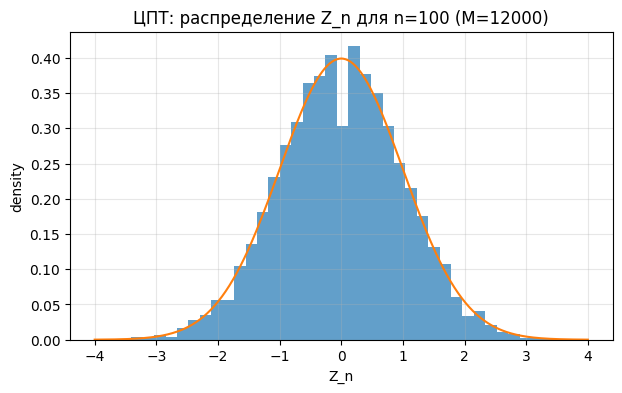

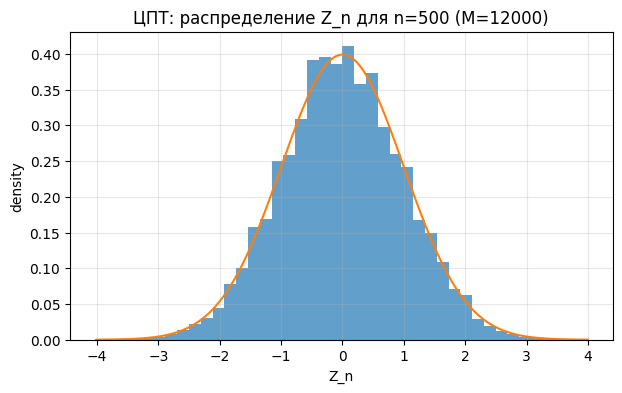

In [4]:

def simulate_Zn(n, M=12000):
    x = np.random.poisson(lam=lam, size=(M, n))
    xb = x.mean(axis=1)
    Zn = (xb - lam) / (np.sqrt(lam / n))
    return Zn

ns = [5, 20, 100, 500]
M = 12000

for n in ns:
    Zn = simulate_Zn(n, M=M)
    plt.figure(figsize=(7, 4))
    plt.hist(Zn, bins=40, density=True, alpha=0.7)
    grid = np.linspace(-4, 4, 400)
    plt.plot(grid, norm.pdf(grid))
    plt.title(f"ЦПТ: распределение Z_n для n={n} (M={M})")
    plt.xlabel("Z_n")
    plt.ylabel("density")
    plt.grid(True, alpha=0.3)
    plt.show()



**Вывод:** при росте `n` гистограмма \(Z_n\) всё лучше совпадает с плотностью стандартного нормального распределения, что иллюстрирует ЦПТ.



## **3–5) Доверительные интервалы для маленькой/средней/большой выборки**

Для каждой из трёх выборок построим:

1) **Асимптотический ДИ для среднего по ЦПТ** (z-критическое значение)  
2) **t-интервал для среднего** (t-критическое значение)  
3) **Бутстрэп Эфрона (percentile) ДИ** для:
   - среднего
   - медианы
   - моды
   - дисперсии

Затем соберём **сводный датафрейм** и сравним ширины ДИ и попадание истинных значений.


In [5]:

sizes = {
    "small (n=30)": 30,
    "medium (n=200)": 200,
    "large (n=2000)": 2000,
}

B = 5000  # бутстрэп-итерации

rows = []

for label, n in sizes.items():
    x = np.random.poisson(lam=lam, size=n)

    # mean CIs
    ci_mean_clt = ci_clt_mean(x, alpha=alpha)
    ci_mean_t = ci_t_mean(x, alpha=alpha)

    # bootstrap CIs
    ci_mean_boot = bootstrap_ci(x, np.mean, B=B, alpha=alpha, random_state=1)
    ci_median_boot = bootstrap_ci(x, np.median, B=B, alpha=alpha, random_state=2)
    ci_mode_boot = bootstrap_ci(x, sample_mode_discrete, B=B, alpha=alpha, random_state=3)
    ci_var_boot = bootstrap_ci(x, lambda a: np.var(a, ddof=1), B=B, alpha=alpha, random_state=4)

    def add(stat_name, ci, true_value, method):
        rows.append({
            "sample": label,
            "n": n,
            "stat": stat_name,
            "method": method,
            "CI_low": ci[0],
            "CI_high": ci[1],
            "CI_width": ci_width(ci),
            "contains_true?": inside(true_value, ci) if true_value is not None else np.nan,
            "true_value": true_value,
        })

    add("mean", ci_mean_clt, true_mean, "CLT (z)")
    add("mean", ci_mean_t, true_mean, "t-interval")
    add("mean", ci_mean_boot, true_mean, "bootstrap (Efron)")

    # Для медианы и моды "истина" зависит от λ (можно вычислять, но для ДЗ обычно достаточно бутстрэпа).
    # Поэтому true_value ставим как None, чтобы не делать лишних утверждений.
    add("median", ci_median_boot, None, "bootstrap (Efron)")
    add("mode", ci_mode_boot, None, "bootstrap (Efron)")

    add("variance", ci_var_boot, true_var, "bootstrap (Efron)")

df = pd.DataFrame(rows)
df_sorted = df.sort_values(["n", "stat", "method"]).reset_index(drop=True)
df_sorted


,sample,n,stat,method,CI_low,CI_high,CI_width,contains_true?,true_value
0,small (n=30),30,mean,CLT (z),5.130892,7.069108,1.938216,True,7.0
1,small (n=30),30,mean,bootstrap (Efron),5.200000,7.066667,1.866667,True,7.0
2,small (n=30),30,mean,t-interval,5.088732,7.111268,2.022536,True,7.0
3,small (n=30),30,median,bootstrap (Efron),4.500000,7.000000,2.500000,NaN,NaN
4,small (n=30),30,mode,bootstrap (Efron),3.000000,8.000000,5.000000,NaN,NaN
5,small (n=30),30,variance,bootstrap (Efron),3.429885,11.109655,7.679770,True,7.0
6,medium (n=200),200,mean,CLT (z),6.703503,7.446497,0.742994,True,7.0
7,medium (n=200),200,mean,bootstrap (Efron),6.709875,7.445000,0.735125,True,7.0
8,medium (n=200),200,mean,t-interval,6.701230,7.448770,0.747541,True,7.0
9,medium (n=200),200,median,bootstrap (Efron),6.000000,7.000000,1.000000,NaN,NaN


In [6]:

# Табличка
df_pretty = df_sorted.copy()
for c in ["CI_low", "CI_high", "CI_width", "true_value"]:
    df_pretty[c] = df_pretty[c].astype(float).round(4)

df_pretty = df_pretty[["sample", "n", "stat", "method", "CI_low", "CI_high", "CI_width", "true_value", "contains_true?"]]
df_pretty


,sample,n,stat,method,CI_low,CI_high,CI_width,true_value,contains_true?
0,small (n=30),30,mean,CLT (z),5.1309,7.0691,1.9382,7.0,True
1,small (n=30),30,mean,bootstrap (Efron),5.2000,7.0667,1.8667,7.0,True
2,small (n=30),30,mean,t-interval,5.0887,7.1113,2.0225,7.0,True
3,small (n=30),30,median,bootstrap (Efron),4.5000,7.0000,2.5000,NaN,NaN
4,small (n=30),30,mode,bootstrap (Efron),3.0000,8.0000,5.0000,NaN,NaN
5,small (n=30),30,variance,bootstrap (Efron),3.4299,11.1097,7.6798,7.0,True
6,medium (n=200),200,mean,CLT (z),6.7035,7.4465,0.7430,7.0,True
7,medium (n=200),200,mean,bootstrap (Efron),6.7099,7.4450,0.7351,7.0,True
8,medium (n=200),200,mean,t-interval,6.7012,7.4488,0.7475,7.0,True
9,medium (n=200),200,median,bootstrap (Efron),6.0000,7.0000,1.0000,NaN,NaN



### **Вывод по пунктам 3–5 (ширины ДИ и соответствие распределению)**

- **Ширины доверительных интервалов уменьшаются при росте `n`**, что ожидаемо: стандартная ошибка среднего \(\propto 1/\sqrt{n}\).
- **t-интервал для среднего** при малых `n` обычно **чуть шире**, чем ЦПТ(z)-интервал (из-за более “тяжёлых хвостов” t-распределения).
- **Бутстрэп Эфрона** позволяет строить ДИ не только для среднего, но и для **медианы, моды, дисперсии** — без вывода сложных формул.
- Для параметров, где есть простой теоретический ориентир (**mean=λ, variance=λ**), столбец `contains_true?` показывает, попадает ли истинное значение в ДИ для конкретно сгенерированной выборки (в малых выборках возможны промахи, в больших — обычно стабильнее).

**Откуда взята выборка:** все выборки — из `Poisson(λ=7)` через `numpy.random.poisson`.
